In [33]:
#carregar os pacotes
%matplotlib inline
import momi		## momi2 analysis
import logging		## create log file
import pickle

In [34]:
#salvar o log
logging.basicConfig(level=logging.INFO,
                    filename="momi_log.txt")

In [8]:
%%bash
cat popmap_prim.txt

#conferir o arquivo popmap

MCI10_Teci_Prim_auri_MZUSP_81988 North
MCI11_Teci_Prim_auri_MZUSP_81989 North
MCI13_Teci_Prim_auri_MZUSP_98832 North
MCI14_Toep_Prim_auri_MZUSP_100445 South
MCI16_Toep_Prim_auri_MZUSP_12233 South
MCI17_Toep_Prim_auri_MZUSP_26704 South
MCI19_Toep_Prim_auri_MZUSP_30157 South
MCI1_Teci_Prim_auri_MZUSP_110797 North
MCI21_Toep_Prim_auri_MZUSP_3939 South
MCI2_Teci_Prim_auri_MZUSP_114969 North
MCI3_Teci_Prim_auri_MZUSP_114970 North
MCI4_Teci_Prim_auri_MZUSP_115213 North
MCI5_Teci_Prim_auri_MZUSP_115214 North
MCI6_Teci_Prim_auri_MZUSP_115215 North
MCI7_Teci_Prim_auri_MZUSP_115216 North
MCI88_Toep_Prim_auri_MZUSP_30155 South
MCI8_Teci_Prim_auri_MZUSP_115217 North
MCI9_Teci_Prim_auri_MZUSP_81200 South


In [10]:
%%bash
ls

pop_map_prim2.csv
popmap_prim.txt
prim95_momi2.bed
prim_95_total.vcf
prim95_unlinked.vcf
prim95_unlinked.vcf.gz
Untitled.ipynb
vcf2bed.R


In [19]:
%%bash
## bgzip performs a blockwise compression
## The -c flag directs bgzip to leave the original vcf file 
##   untouched and create a new file for the vcf.gz
## se o vcf foi salvo em vcf.gz no snpfiltR descomprir o arquivo antes de usar aqui, nao salvar direto como vcf no snpfiltR
bgzip -c prim95_unlinked.vcf > prim95_unlinked.vcf.gz

## tabix indexes the file for searching
tabix prim95_unlinked.vcf.gz
ls

pop_map_prim2.csv
popmap_prim.txt
prim95_momi2.bed
prim_95_total.vcf
prim95_unlinked.vcf
prim95_unlinked.vcf.gz
prim95_unlinked.vcf.gz.tbi
Untitled.ipynb
vcf2bed.R


In [17]:
%%bash

##transformei em bed no R, pacote bedr, função vcf2bed
## Print the first 10 lines of this file
head prim95_momi2.bed

uce-2814_MCI7_Teci_Prim_auri_MZUSP_115216 658 659
uce-841_MCI7_Teci_Prim_auri_MZUSP_115216 624 625
uce-115_MCI7_Teci_Prim_auri_MZUSP_115216 489 490
uce-4030_MCI7_Teci_Prim_auri_MZUSP_115216 142 143
uce-4538_MCI7_Teci_Prim_auri_MZUSP_115216 473 474
uce-7313_MCI7_Teci_Prim_auri_MZUSP_115216 616 617
uce-4316_MCI7_Teci_Prim_auri_MZUSP_115216 602 603
uce-748_MCI7_Teci_Prim_auri_MZUSP_115216 708 709
uce-1581_MCI7_Teci_Prim_auri_MZUSP_115216 614 615
uce-1063_MCI7_Teci_Prim_auri_MZUSP_115216 547 548


In [23]:
%%bash
python -m momi.read_vcf --no_aa --verbose prim95_unlinked.vcf.gz popmap_prim.txt prim_allele_counts.gz --bed prim95_momi2.bed
gunzip -c prim_allele_counts.gz | head

{
	"populations": ["N", "S"],
	"use_folded_sfs": true,
	"length": 425,
	"n_read_snps": 425,
	"n_excluded_snps": 0,
	"configs": [
		[[22, 0], [13, 1]],
		[[22, 0], [12, 2]],
		[[22, 0], [11, 3]],


In [24]:
%%bash
python -m momi.extract_sfs prim_sfs.gz 20 prim_allele_counts.gz

In [25]:
sfs = momi.Sfs.load("prim_sfs.gz")
print("Avg pairwise heterozygosity", sfs.avg_pairwise_hets[:5])
print("populations", sfs.populations)
print("percent missing data per population", sfs.p_missing)

Avg pairwise heterozygosity [[4.4025974  3.67032967]
 [4.21212121 4.3956044 ]
 [3.06926407 4.81318681]
 [3.38528139 2.84615385]
 [6.12987013 7.15384615]]
populations ('N', 'S')
percent missing data per population [0. 0.]


In [54]:
##Os modelos testados sao os mesmos de Bocalini et 2023 Mol Ecol

#Modelo 1a - isolamento sem migração com evento fundador na populacao do Sul

prim_model1a = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model1a.set_data(sfs)

#prim_model1a.add_size_param("n_N", lower=5e3, upper=1e6)
#prim_model1a.add_size_param("n_S", lower=5e3, upper=1e6)

prim_model1a.add_size_param("n_bt", lower=1e3, upper=5e4) 

prim_model1a.add_time_param("tdiv", lower=5e3, upper=5e6)

prim_model1a.add_growth_param("g_S", lower=1e-6, upper=1e-3)

prim_model1a.add_leaf("S", N=2e5, g="g_S")
prim_model1a.add_leaf("N", N=3e4)
prim_model1a.set_size("S", N="n_bt", t="tdiv", g=0)

prim_model1a.move_lineages("N", "S", t="tdiv")

prim_model1a.optimize()



            fun: 1.1093623907839372
            jac: array([-1.02930199e-01,  1.74207717e-06, -1.30743452e-03])
  kl_divergence: 1.1093623907839372
 log_likelihood: -1846.4990995703643
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 32
            nit: 11
     parameters: ParamsDict({'n_bt': 50000.00000000001, 'tdiv': 76749.86013017576, 'g_S': 5.921279134575466e-06})
         status: 1
        success: True
              x: array([ 1.08197783e+01, -4.22853828e+00,  5.92127913e-06])

In [55]:
### repetitions ### para encontrar o melhor valor de likelyhood

results = []
n_runs = 10
prim_model1a_copy = prim_model1a.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model1a.set_params(prim_model1a.get_params(),randomize=True)
    results.append(prim_model1a_copy.optimize(method='L-BFGS-B'))
    lik=prim_model1a_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, choose the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model1a_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)

Starting run 1 out of 10...
-1846.499099570347
Starting run 2 out of 10...
-1846.499099570347
Starting run 3 out of 10...
-1846.499099570347
Starting run 4 out of 10...
-1846.499099570347
Starting run 5 out of 10...
-1846.499099570347
Starting run 6 out of 10...
-1846.499099570347
Starting run 7 out of 10...
-1846.499099570347
Starting run 8 out of 10...
-1846.499099570347
Starting run 9 out of 10...
-1846.499099570347
Starting run 10 out of 10...
-1846.499099570347


In [56]:
#### output ## salvar os parametros em um .txt
file = open("bestrun_prim.txt","a")
file.write("Model=model1a" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo .pkl

prim_model1a = best_result
f = open("prim_model1a.pkl","wb")
pickle.dump(prim_model1a,f)
f.close()

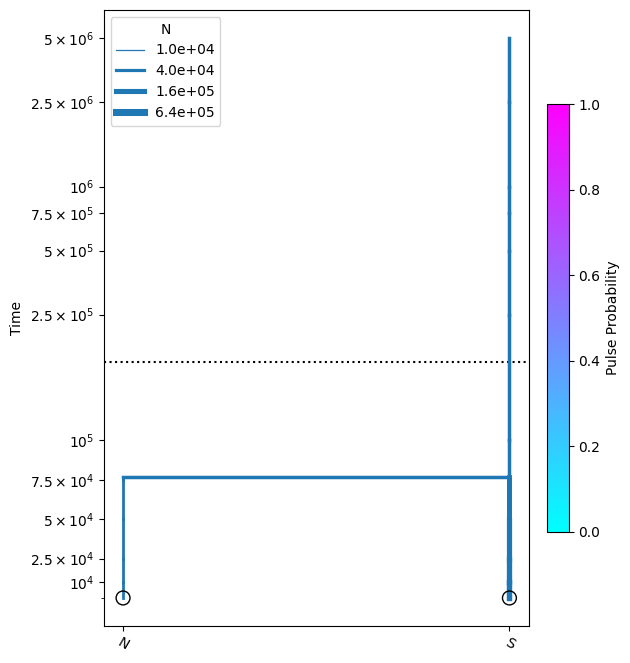

In [57]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model1a_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [58]:
#Modelo 1b - isolamento sem migração com evento fundador na populacao do Norte - bt (bottleneck)
prim_model1b = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model1b.set_data(sfs)

#prim_model1b.add_size_param("n_N", lower=5e3, upper=1e6)
#prim_model1b.add_size_param("n_S", lower=5e3, upper=1e6)
prim_model1b.add_size_param("n_bt", lower=1e3, upper=5e4)

prim_model1b.add_time_param("tdiv", lower=5e3, upper=5e6)

prim_model1b.add_growth_param("g_N", lower=1e-6, upper=1e-3)

prim_model1b.add_leaf("S", N=2e5)
prim_model1b.add_leaf("N", N=3e4, g="g_N")
prim_model1b.set_size("N", N="n_bt", t="tdiv", g=0)

prim_model1b.move_lineages("N", "S", t="tdiv")

prim_model1b.optimize()

            fun: 0.996027223321876
            jac: array([0.00000000e+00, 1.07023597e-08, 2.01640522e+03])
  kl_divergence: 0.996027223321876
 log_likelihood: -1798.3316533989882
        message: 'Local minimum reached (|pg| ~= 0)'
           nfev: 24
            nit: 8
     parameters: ParamsDict({'n_bt': 26770.03404422686, 'tdiv': 62152.52459626758, 'g_N': 1.0000000000000243e-06})
         status: 0
        success: True
              x: array([ 1.01950384e+01, -4.45896122e+00,  1.00000000e-06])

In [59]:
### repetitions ###

results = []
n_runs = 10
prim_model1b_copy = prim_model1b.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model1b.set_params(prim_model1b.get_params(),randomize=True)
    results.append(prim_model1b_copy.optimize(method='L-BFGS-B'))
    lik=prim_model1b_copy.log_likelihood()
    print(lik)

best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model1b_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)

Starting run 1 out of 10...
-1798.3316533989882
Starting run 2 out of 10...
-1798.3316533989882
Starting run 3 out of 10...
-1798.3316533989882
Starting run 4 out of 10...
-1798.3316533989882
Starting run 5 out of 10...
-1798.3316533989882
Starting run 6 out of 10...
-1798.3316533989882
Starting run 7 out of 10...
-1798.3316533989882
Starting run 8 out of 10...
-1798.3316533989882
Starting run 9 out of 10...
-1798.3316533989882
Starting run 10 out of 10...
-1798.3316533989882


In [60]:
#### output
file = open("bestrun_prim.txt","a")
file.write("Model=model1b" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model1a = best_result
f = open("prim_model1b.pkl","wb")
pickle.dump(prim_model1a,f)
f.close()

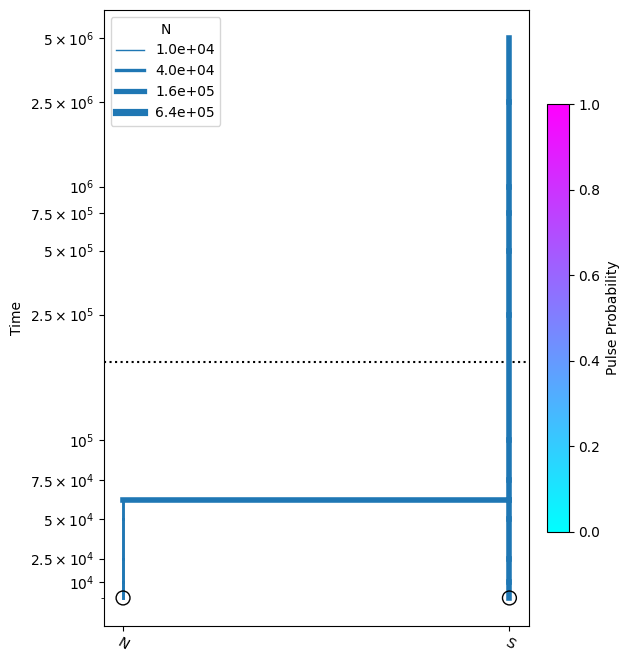

In [61]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model1b_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [67]:
#Modelo 1c- isolamento sem migração com evento fundador no Sul e expansão no Norte

prim_model1c = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model1c.set_data(sfs)

#prim_model1c.add_size_param("n_N", lower=5e3, upper=1e6)
#prim_model1c.add_size_param("n_S", lower=5e3, upper=1e6)
prim_model1c.add_size_param("n_bt", lower=1e3, upper=5e4)

prim_model1c.add_time_param("tdiv", lower=5e3, upper=5e6)

prim_model1c.add_growth_param("g_S", lower=1e-6, upper=1e-3)
prim_model1c.add_growth_param("g_N", lower=1e-6, upper=1e-3)

prim_model1c.add_leaf("S", N=2e5, g="g_S")
prim_model1c.add_leaf("N", N=3e4, g="g_N")
prim_model1c.set_size("S", N="n_bt", t="tdiv", g=0)
prim_model1c.set_size("N",t="tdiv", g=0)

prim_model1c.move_lineages("N", "S", t="tdiv")

prim_model1c.optimize()

            fun: 1.1116781734299879
            jac: array([-1.01222771e-01,  7.94589008e-13,  1.80420262e-08,  2.27133612e+03])
  kl_divergence: 1.1116781734299879
 log_likelihood: -1847.4833071949358
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 46
            nit: 13
     parameters: ParamsDict({'n_bt': 50000.00000000001, 'tdiv': 73664.49663050915, 'g_S': 7.024408328214346e-06, 'g_N': 1.0000000000000243e-06})
         status: 1
        success: True
              x: array([ 1.08197783e+01, -4.27311841e+00,  7.02440833e-06,  1.00000000e-06])

In [68]:
### repetitions ###

results = []
n_runs = 10
prim_model1c_copy = prim_model1c.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model1c.set_params(prim_model1c.get_params(),randomize=True)
    results.append(prim_model1c_copy.optimize(method='L-BFGS-B'))
    lik=prim_model1c_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model1c_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)

Starting run 1 out of 10...
-1847.4833071949358
Starting run 2 out of 10...
-1847.4833071949358
Starting run 3 out of 10...
-1847.4833071949358
Starting run 4 out of 10...
-1847.4833071949358
Starting run 5 out of 10...
-1847.4833071949358
Starting run 6 out of 10...
-1847.4833071949358
Starting run 7 out of 10...
-1847.4833071949358
Starting run 8 out of 10...
-1847.4833071949358
Starting run 9 out of 10...
-1847.4833071949358
Starting run 10 out of 10...
-1847.4833071949358


In [69]:
#### output
file = open("bestrun_prim.txt","a")
file.write("Model=model1c" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model1c = best_result
f = open("prim_model1c.pkl","wb")
pickle.dump(prim_model1c,f)
f.close()


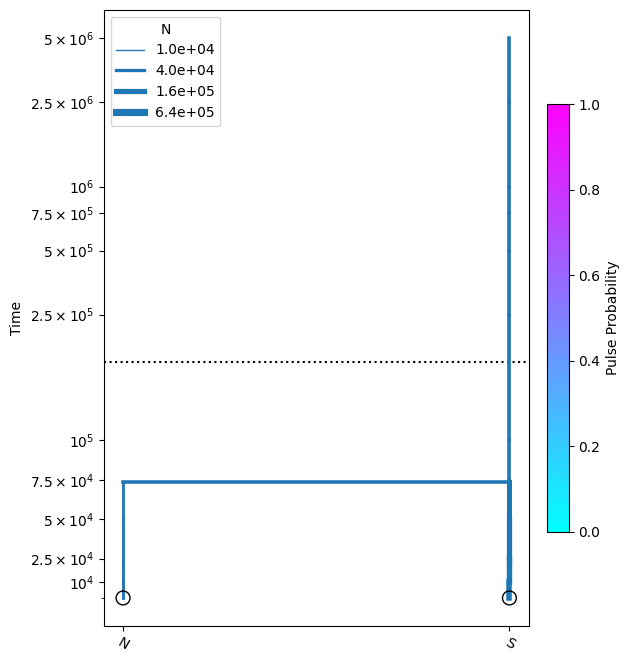

In [70]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model1c_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [72]:
#Modelo 1d - isolamento sem migração com evento fundador na N e expansão na MA
prim_model1d = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model1d.set_data(sfs)

#prim_model1d.add_size_param("n_N", lower=5e3, upper=1e6)
#prim_model1d.add_size_param("n_S", lower=5e3, upper=1e6)
prim_model1d.add_size_param("n_bt", lower=1e3, upper=5e4)

prim_model1d.add_time_param("tdiv", lower=5e3, upper=5e6)

prim_model1d.add_growth_param("g_S", lower=1e-6, upper=1e-3)
prim_model1d.add_growth_param("g_N", lower=1e-6, upper=1e-3)

prim_model1d.add_leaf("S", N=2e5, g="g_S")
prim_model1d.add_leaf("N", N=3e4, g="g_N")
prim_model1d.set_size("S", t="tdiv", g=0)
prim_model1d.set_size("N",N="n_bt",t="tdiv", g=0)

prim_model1d.move_lineages("N", "S", t="tdiv")

prim_model1d.optimize()

            fun: 1.0016981090332757
            jac: array([0.00000000e+00, 1.34473352e-07, 5.61065151e+03, 1.86887517e+03])
  kl_divergence: 1.0016981090332757
 log_likelihood: -1800.7417798263332
        message: 'Local minimum reached (|pg| ~= 0)'
           nfev: 35
            nit: 9
     parameters: ParamsDict({'n_bt': 34122.64153295619, 'tdiv': 61624.02382449008, 'g_S': 1.0000000000000243e-06, 'g_N': 1.0000000000000243e-06})
         status: 0
        success: True
              x: array([ 1.04377164e+01, -4.46835846e+00,  1.00000000e-06,  1.00000000e-06])

In [73]:
### repetitions ###

results = []
n_runs = 10
prim_model1d_copy = prim_model1d.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model1d.set_params(prim_model1d.get_params(),randomize=True)
    results.append(prim_model1d_copy.optimize(method='L-BFGS-B'))
    lik=prim_model1d_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model1d_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)


Starting run 1 out of 10...
-1800.7417798263332
Starting run 2 out of 10...
-1800.7417798263332
Starting run 3 out of 10...
-1800.7417798263332
Starting run 4 out of 10...
-1800.7417798263332
Starting run 5 out of 10...
-1800.7417798263332
Starting run 6 out of 10...
-1800.7417798263332
Starting run 7 out of 10...
-1800.7417798263332
Starting run 8 out of 10...
-1800.7417798263332
Starting run 9 out of 10...
-1800.7417798263332
Starting run 10 out of 10...
-1800.7417798263332


In [74]:
#### output
file = open("bestrun_prim.txt","a")
file.write("Model=model1d" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model1d = best_result
f = open("prim_model1d.pkl","wb")
pickle.dump(prim_model1d,f)
f.close()

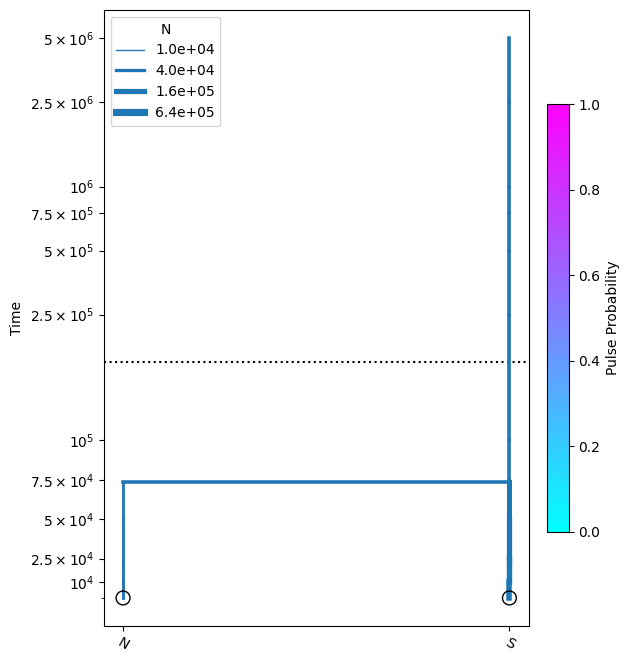

In [75]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model1d_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [77]:
#Modelo 1e - isolamento com migração com evento fundador no Sul
prim_model1e = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model1e.set_data(sfs)

#prim_model1e.add_size_param("n_N", lower=5e3, upper=1e6)
#prim_model1e.add_size_param("n_S", lower=5e3, upper=1e6)
prim_model1e.add_size_param("n_bt", lower=1e3, upper=5e4)

prim_model1e.add_time_param("tmig_N_S", lower=5e3, upper=5e6)
prim_model1e.add_time_param("tmig_S_N", lower=5e3, upper=5e6)
prim_model1e.add_pulse_param("mfrac_N_S", upper=.2)
prim_model1e.add_pulse_param("mfrac_S_N", upper=.2)

prim_model1e.add_time_param("tdiv", lower=5e3, upper=5e6, lower_constraints=["tmig_N_S", "tmig_S_N"])

prim_model1e.add_growth_param("g_S", lower=1e-6, upper=1e-3)

prim_model1e.add_leaf("S", N=2e5, g="g_S")
prim_model1e.add_leaf("N", N=3e4)
prim_model1e.set_size("S", N="n_bt", t="tdiv", g=0)

prim_model1e.move_lineages("N", "S", t="tmig_N_S", p="mfrac_N_S")
prim_model1e.move_lineages("S", "N", t="tmig_S_N", p="mfrac_S_N")
prim_model1e.move_lineages("N", "S", t="tdiv")

prim_model1e.optimize()


            fun: 1.0922200322806561
            jac: array([-1.11742529e-01, -4.74208196e-06, -2.90826187e-05, -1.19771922e-02,
        6.51344114e-09, -1.44138257e-08,  8.90268272e+01])
  kl_divergence: 1.0922200322806561
 log_likelihood: -1839.2135972064698
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 64
            nit: 14
     parameters: ParamsDict({'n_bt': 50000.00000000001, 'tmig_N_S': 24168.64641369865, 'tmig_S_N': 122570.83696379625, 'mfrac_N_S': 0.2, 'mfrac_S_N': 0.00023271601297715974, 'tdiv': 122653.46599605976, 'g_S': 1.0000000000000243e-06})
         status: 1
        success: True
              x: array([ 1.08197783e+01, -5.55907180e+00, -3.72533253e+00, -1.38629436e+00,
       -8.36545893e+00, -1.09857508e+01,  1.00000000e-06])

In [78]:
### repetitions ###

results = []
n_runs = 10
prim_model1e_copy = prim_model1e.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model1e.set_params(prim_model1e.get_params(),randomize=True)
    results.append(prim_model1e_copy.optimize(method='L-BFGS-B'))
    lik=prim_model1e_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model1e_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)

Starting run 1 out of 10...
-1839.213596864182
Starting run 2 out of 10...
-1839.2135966190822
Starting run 3 out of 10...
-1839.2135964416243
Starting run 4 out of 10...
-1839.2135963133098
Starting run 5 out of 10...
-1839.2135962222617
Starting run 6 out of 10...
-1839.2135961557606
Starting run 7 out of 10...
-1839.2135961070135
Starting run 8 out of 10...
-1839.2135961070135
Starting run 9 out of 10...
-1839.2135961070135
Starting run 10 out of 10...
-1839.2135961070135


In [79]:
#### output
file = open("bestrun_prim.txt","a")
file.write("Model=model1e" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

cary_model1e = best_result
f = open("prim_model1e.pkl","wb")
pickle.dump(cary_model1e,f)
f.close()


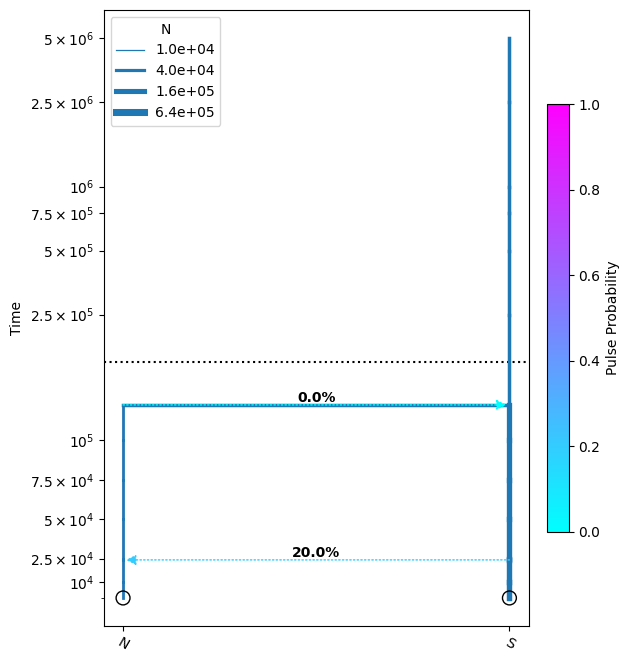

In [80]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model1e_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [85]:
#Modelo 1f- isolamento com migração com evento fundador no Norte
prim_model1f = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model1f.set_data(sfs)

#prim_model1f.add_size_param("n_N", lower=5e3, upper=1e6)
#prim_model1f.add_size_param("n_S", lower=5e3, upper=1e6)
prim_model1f.add_size_param("n_bt", lower=1e3, upper=5e4)

prim_model1f.add_time_param("tmig_N_S", lower=5e3, upper=5e6)
prim_model1f.add_time_param("tmig_S_N", lower=5e3, upper=5e6)
prim_model1f.add_pulse_param("mfrac_N_S", upper=.2)
prim_model1f.add_pulse_param("mfrac_S_N", upper=.2)

prim_model1f.add_time_param("tdiv", lower=5e3, upper=5e6, lower_constraints=["tmig_N_S", "tmig_S_N"])

prim_model1f.add_growth_param("g_N", lower=1e-6, upper=1e-3)

prim_model1f.add_leaf("S", N=2e5)
prim_model1f.add_leaf("N", N=3e4, g="g_N",)
prim_model1f.set_size("N", N="n_bt", t="tdiv", g=0)

prim_model1f.move_lineages("N", "S", t="tmig_N_S", p="mfrac_N_S")
prim_model1f.move_lineages("S", "N", t="tmig_S_N", p="mfrac_S_N")
prim_model1f.move_lineages("N", "S", t="tdiv")

prim_model1f.optimize()

            fun: 0.9861764002485223
            jac: array([ 0.00000000e+00,  3.48688686e-07, -2.07837456e-07, -5.20639554e-03,
        7.50812305e-09,  3.94994648e-09,  2.75280356e+03])
  kl_divergence: 0.9861764002485223
 log_likelihood: -1794.145053592813
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 95
            nit: 18
     parameters: ParamsDict({'n_bt': 21597.139942515678, 'tmig_N_S': 21514.25893314286, 'tmig_S_N': 95059.45943839393, 'mfrac_N_S': 0.2, 'mfrac_S_N': 1.819637371652652e-06, 'tdiv': 96568.9815546136, 'g_N': 1.0000000000000243e-06})
         status: 1
        success: True
              x: array([ 9.98031617e+00, -5.70865687e+00, -3.99752814e+00, -1.38629436e+00,
       -1.32168715e+01, -8.08589733e+00,  1.00000000e-06])

In [86]:
### repetitions ###

results = []
n_runs = 10
prim_model1f_copy = prim_model1f.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model1f.set_params(prim_model1f.get_params(),randomize=True)
    results.append(prim_model1f_copy.optimize(method='L-BFGS-B'))
    lik=prim_model1f_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model1f_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)

Starting run 1 out of 10...
-1794.145053592813
Starting run 2 out of 10...
-1794.145053592813
Starting run 3 out of 10...
-1794.145053592813
Starting run 4 out of 10...
-1794.145053592813
Starting run 5 out of 10...
-1794.145053592813
Starting run 6 out of 10...
-1794.145053592813
Starting run 7 out of 10...
-1794.145053592813
Starting run 8 out of 10...
-1794.145053592813
Starting run 9 out of 10...
-1794.145053592813
Starting run 10 out of 10...
-1794.145053592813


In [87]:
#### output
file = open("bestrun_prim.txt","a")
file.write("Model=model1f" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model1f = best_result
f = open("prim_model1f.pkl","wb")
pickle.dump(prim_model1f,f)
f.close()


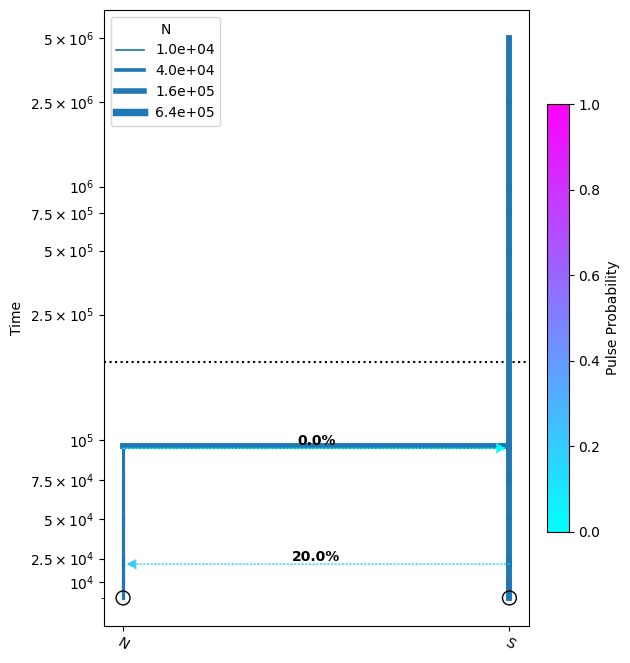

In [88]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model1f_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [94]:
#Modelo 1g- isolamento com migração com evento fundador no Sul e expansão no Norte
prim_model1g = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model1g.set_data(sfs)

#prim_model1g.add_size_param("n_N", lower=5e3, upper=1e6)
#prim_model1g.add_size_param("n_S", lower=5e3, upper=1e6)
prim_model1g.add_size_param("n_bt", lower=1e3, upper=5e4)

prim_model1g.add_time_param("tmig_N_S", lower=5e3, upper=5e6)
prim_model1g.add_time_param("tmig_S_N", lower=5e3, upper=5e6)
prim_model1g.add_pulse_param("mfrac_N_S", upper=.2)
prim_model1g.add_pulse_param("mfrac_S_N", upper=.2)

prim_model1g.add_time_param("tdiv", lower=5e3, upper=5e6, lower_constraints=["tmig_N_S", "tmig_S_N"])

prim_model1g.add_growth_param("g_S", lower=1e-6, upper=1e-3)
prim_model1g.add_growth_param("g_N", lower=1e-6, upper=1e-3)

prim_model1g.add_leaf("S", N=2e5, g="g_S")
prim_model1g.add_leaf("N", N=3e4, g="g_N")
prim_model1g.set_size("S", N="n_bt", t="tdiv", g=0)
prim_model1g.set_size("N",t="tdiv", g=0)

prim_model1g.move_lineages("N", "S", t="tmig_N_S", p="mfrac_N_S")
prim_model1g.move_lineages("S", "N", t="tmig_S_N", p="mfrac_S_N")
prim_model1g.move_lineages("N", "S", t="tdiv")

prim_model1g.optimize()

            fun: 1.0953597894585763
            jac: array([-1.09641434e-01,  4.43543054e-10, -1.07809739e-08, -1.14142749e-02,
        2.99992061e-08,  3.83670228e-09,  7.46341075e+01,  3.04370586e+03])
  kl_divergence: 1.0953597894585763
 log_likelihood: -1840.547994007086
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 100
            nit: 19
     parameters: ParamsDict({'n_bt': 50000.00000000001, 'tmig_N_S': 24198.641516244854, 'tmig_S_N': 26693.57278298171, 'mfrac_N_S': 0.2, 'mfrac_S_N': 4.352933582123091e-07, 'tdiv': 114816.39251133519, 'g_S': 1.0000000000000243e-06, 'g_N': 1.0000000000000243e-06})
         status: 1
        success: True
              x: array([ 1.08197783e+01, -5.55750219e+00, -5.43482414e+00, -1.38629436e+00,
       -1.46472452e+01, -4.01523063e+00,  1.00000000e-06,  1.00000000e-06])

In [95]:
### repetitions ###

results = []
n_runs = 10
prim_model1g_copy = prim_model1g.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model1g.set_params(prim_model1g.get_params(),randomize=True)
    results.append(prim_model1g_copy.optimize(method='L-BFGS-B'))
    lik=prim_model1g_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model1g_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)

Starting run 1 out of 10...
-1840.547994007086
Starting run 2 out of 10...
-1840.547994007086
Starting run 3 out of 10...
-1840.547994007086
Starting run 4 out of 10...
-1840.547994007086
Starting run 5 out of 10...
-1840.547994007086
Starting run 6 out of 10...
-1840.547994007086
Starting run 7 out of 10...
-1840.547994007086
Starting run 8 out of 10...
-1840.547994007086
Starting run 9 out of 10...
-1840.547994007086
Starting run 10 out of 10...
-1840.547994007086


In [97]:
#### output
file = open("bestrun_prim.txt","a")
file.write("Model=model1g" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model1g = best_result
f = open("prim_model1g.pkl","wb")
pickle.dump(prim_model1g,f)
f.close()

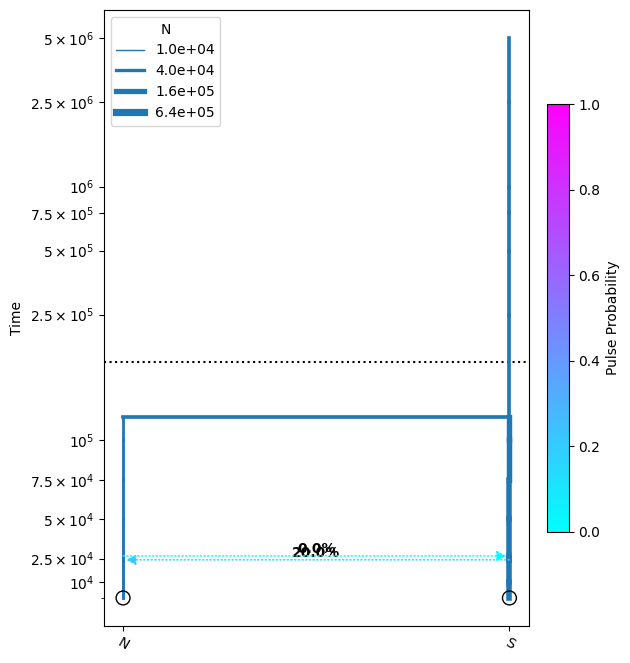

In [98]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model1g_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [99]:
#Modelo 1h - isolamento com migração com evento fundador no N e expansão no Sul 
prim_model1h = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model1h.set_data(sfs)

#prim_model1h.add_size_param("n_N", lower=5e3, upper=1e6)
#prim_model1h.add_size_param("n_S", lower=5e3, upper=1e6)
prim_model1h.add_size_param("n_bt", lower=1e3, upper=5e4)

prim_model1h.add_time_param("tmig_N_S", lower=5e3, upper=5e6)
prim_model1h.add_time_param("tmig_S_N", lower=5e3, upper=5e6)
prim_model1h.add_pulse_param("mfrac_N_S", upper=.2)
prim_model1h.add_pulse_param("mfrac_S_N", upper=.2)

prim_model1h.add_time_param("tdiv", lower=5e3, upper=5e6, lower_constraints=["tmig_N_S", "tmig_S_N"])

prim_model1h.add_growth_param("g_S", lower=1e-6, upper=1e-3)
prim_model1h.add_growth_param("g_N", lower=1e-6, upper=1e-3)

prim_model1h.add_leaf("S", N=2e5, g="g_S")
prim_model1h.add_leaf("N", N=3e4, g="g_N")
prim_model1h.set_size("N",t="tdiv", N="n_bt", g=0)
prim_model1h.set_size("S",t="tdiv", g=0)

prim_model1h.move_lineages("N", "S", t="tmig_N_S", p="mfrac_N_S")
prim_model1h.move_lineages("S", "N", t="tmig_S_N", p="mfrac_S_N")
prim_model1h.move_lineages("N", "S", t="tdiv")

prim_model1h.optimize()


            fun: 0.9996265170066042
            jac: array([ 0.00000000e+00,  7.58247071e-04,  1.36097120e-02, -1.25633178e-02,
        2.58434238e-03,  1.10316718e-02,  8.50886982e+03,  4.54477988e+03])
  kl_divergence: 0.9996265170066042
 log_likelihood: -1799.8613532149977
        message: 'Max. number of function evaluations reached'
           nfev: 101
            nit: 18
     parameters: ParamsDict({'n_bt': 6262.164169212683, 'tmig_N_S': 20639.465091240374, 'tmig_S_N': 72627.43446115535, 'mfrac_N_S': 0.19999999999999996, 'mfrac_S_N': 0.035025710651309036, 'tdiv': 113121.6314113755, 'g_S': 1.0000000000000243e-06, 'g_N': 1.0000000000000243e-06})
         status: 3
        success: False
              x: array([ 8.74228112e+00, -5.76325922e+00, -4.28854744e+00, -1.38629436e+00,
       -3.31601908e+00, -4.79315033e+00,  1.00000000e-06,  1.00000000e-06])

In [100]:
### repetitions ###

results = []
n_runs = 10
prim_model1h_copy = prim_model1h.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model1h.set_params(prim_model1h.get_params(),randomize=True)
    results.append(prim_model1h_copy.optimize(method='L-BFGS-B'))
    lik=prim_model1h_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model1h_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)


Starting run 1 out of 10...
-1798.970921550602
Starting run 2 out of 10...
-1798.413937567695
Starting run 3 out of 10...
-1798.2907909098815
Starting run 4 out of 10...
-1798.206627662708
Starting run 5 out of 10...
-1798.1417146322487
Starting run 6 out of 10...
-1798.0919256806776
Starting run 7 out of 10...
-1798.0509090172409
Starting run 8 out of 10...
-1798.0174636816282
Starting run 9 out of 10...
-1797.9887897064743
Starting run 10 out of 10...
-1797.9431252087033


In [101]:
#### output
file = open("bestrun_prim.txt","a")
file.write("Model=model1h" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model1h = best_result
f = open("prim_model1h.pkl","wb")
pickle.dump(prim_model1h,f)
f.close()


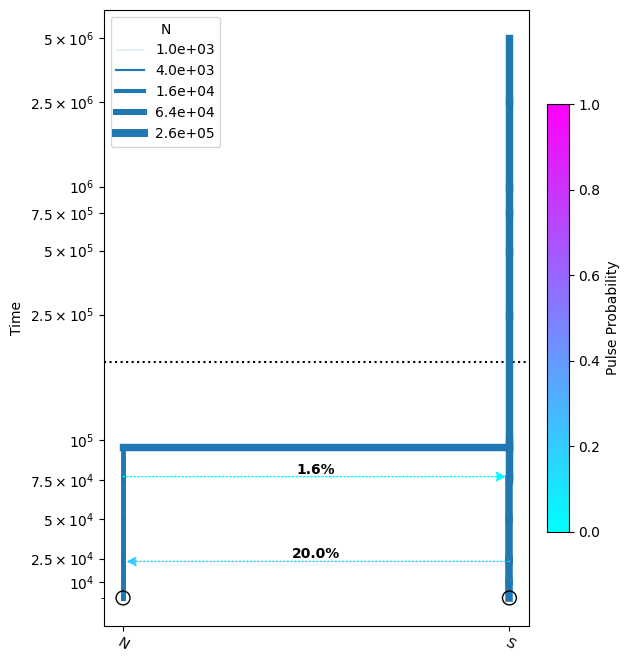

In [102]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model1h_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [103]:
#Modelo 2a - isolamento sem migração como expansão do S
prim_model2a = momi.DemographicModel(N_e=1e5, gen_time=4.72,muts_per_gen=2.5e-9)

prim_model2a.set_data(sfs)
prim_model2a.add_time_param("tdiv",lower=5e3,upper=5e6)
prim_model2a.add_growth_param("g_S", lower=1e-6, upper=1e-3)

prim_model2a.add_leaf("N", N=2e5)
prim_model2a.add_leaf("S", N=3e4, g="g_S")
prim_model2a.set_size("S", t="tdiv", g=0)

prim_model2a.move_lineages("N", "S", t="tdiv")

prim_model2a.optimize()


            fun: 1.390706246570322
            jac: array([4.85010329e-08, 9.42566278e+03])
  kl_divergence: 1.390706246570322
 log_likelihood: -1966.0702382795778
        message: 'Local minimum reached (|pg| ~= 0)'
           nfev: 14
            nit: 5
     parameters: ParamsDict({'tdiv': 53997.66668485337, 'g_S': 1.0000000000000243e-06})
         status: 0
        success: True
              x: array([-4.61456224e+00,  1.00000000e-06])

In [104]:
### repetitions ###

results = []
n_runs = 10
prim_model2a_copy = prim_model2a.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model2a.set_params(prim_model2a.get_params(),randomize=True)
    results.append(prim_model2a_copy.optimize(method='L-BFGS-B'))
    lik=prim_model2a_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model2a_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)

Starting run 1 out of 10...
-1966.0702382795778
Starting run 2 out of 10...
-1966.0702382795778
Starting run 3 out of 10...
-1966.0702382795778
Starting run 4 out of 10...
-1966.0702382795778
Starting run 5 out of 10...
-1966.0702382795778
Starting run 6 out of 10...
-1966.0702382795778
Starting run 7 out of 10...
-1966.0702382795778
Starting run 8 out of 10...
-1966.0702382795778
Starting run 9 out of 10...
-1966.0702382795778
Starting run 10 out of 10...
-1966.0702382795778


In [105]:
#### output
file = open("bestrun_prim.txt","a")
file.write("Model=model2a" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model2a = best_result
f = open("prim_model2a.pkl","wb")
pickle.dump(prim_model2a,f)
f.close()


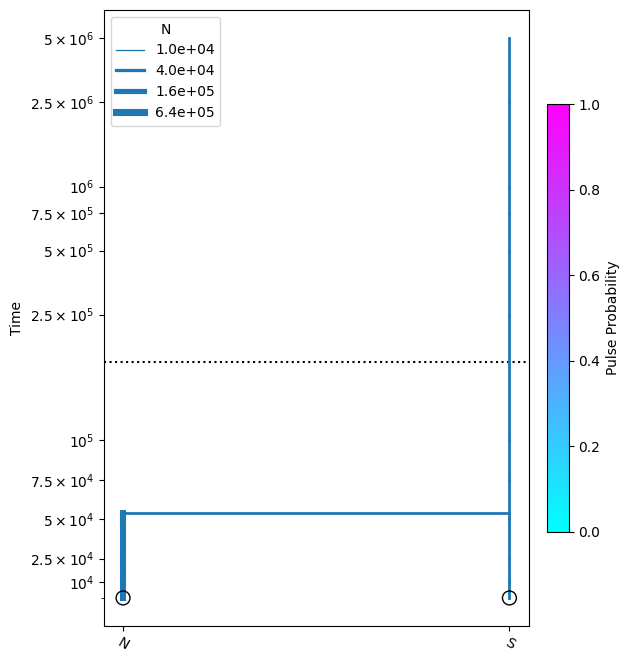

In [106]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model2a_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [113]:
#Modelo 2b - isolamento sem migração como expansão da N

prim_model2b = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model2b.set_data(sfs)

#prim_model2b.add_size_param("n_N", lower=5e3,upper=1e6)
#prim_model2b.add_size_param("n_S",lower=5e3,upper=1e6)
prim_model2b.add_time_param("tdiv", lower=5e3,upper=5e6)
prim_model2b.add_growth_param("g_N", lower=1e-6, upper=1e-3)

prim_model2b.add_leaf("S",N=2e5)
prim_model2b.add_leaf("N", N=3e4, g="g_N")
prim_model2b.set_size("N", t="tdiv", g=0)

prim_model2b.move_lineages("N", "S", t="tdiv")

prim_model2b.optimize()


            fun: 0.9960272233218749
            jac: array([1.35094860e-12, 2.01640475e+03])
  kl_divergence: 0.9960272233218749
 log_likelihood: -1798.3316533989878
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 10
            nit: 4
     parameters: ParamsDict({'tdiv': 62152.5217540327, 'g_N': 1.0000000000000243e-06})
         status: 1
        success: True
              x: array([-4.45896127e+00,  1.00000000e-06])

In [114]:
### repetitions ###

results = []
n_runs = 10
prim_model2b_copy = prim_model2b.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model2b.set_params(prim_model2b.get_params(),randomize=True)
    results.append(prim_model2b_copy.optimize(method='L-BFGS-B'))
    lik=prim_model2b_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model2b_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)


Starting run 1 out of 10...
-1798.3316533989878
Starting run 2 out of 10...
-1798.3316533989878
Starting run 3 out of 10...
-1798.3316533989878
Starting run 4 out of 10...
-1798.3316533989878
Starting run 5 out of 10...
-1798.3316533989878
Starting run 6 out of 10...
-1798.3316533989878
Starting run 7 out of 10...
-1798.3316533989878
Starting run 8 out of 10...
-1798.3316533989878
Starting run 9 out of 10...
-1798.3316533989878
Starting run 10 out of 10...
-1798.3316533989878


In [115]:
#### output
file = open("bestrun_prim.txt","a")
file.write("Model=model2b" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model2b = best_result
f = open("prim_model2b.pkl","wb")
pickle.dump(prim_model2b,f)
f.close()

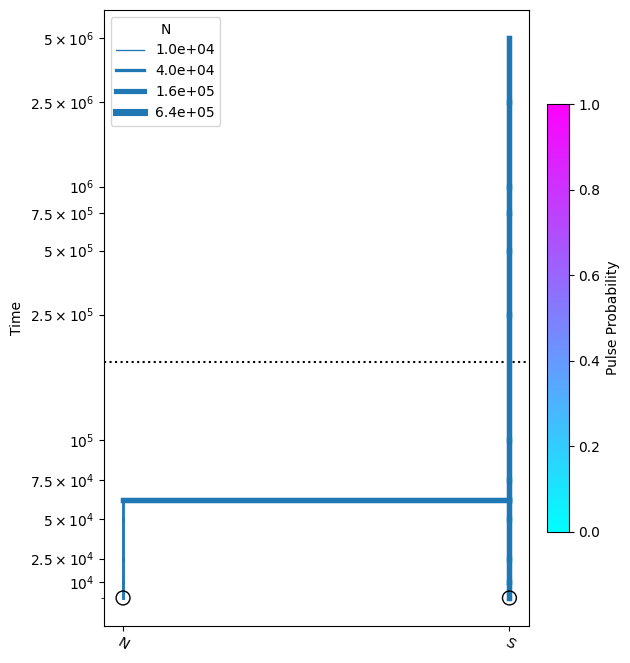

In [117]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model2b_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [121]:
#Modelo 2c - migração para os dois lados com expansão do S
prim_model2c = momi.DemographicModel(N_e=1e5,gen_time=4.72, muts_per_gen=2.5e-9)

prim_model2c.set_data(sfs)

prim_model2c.add_time_param("tmig_N_S", lower=5e3, upper=5e6)
prim_model2c.add_time_param("tmig_S_N", lower=5e3, upper=5e6)
prim_model2c.add_pulse_param("mfrac_N_S", upper=.2)
prim_model2c.add_pulse_param("mfrac_S_N", upper=.2)

prim_model2c.add_time_param("tdiv",lower=5e3, upper=5e6, lower_constraints=["tmig_N_S", "tmig_S_N"])

#prim_model2c.add_size_param("n_S", lower=5e3,upper=1e6)
#prim_model2c.add_size_param("n_N", lower=5e3,upper=1e6)
prim_model2c.add_growth_param("g_S", lower=1e-6, upper=1e-3)


prim_model2c.add_leaf("N", N=2e5)
prim_model2c.add_leaf("S", N=3e4, g="g_S")
prim_model2c.move_lineages("N", "S", t="tmig_N_S", p="mfrac_N_S")
prim_model2c.move_lineages("S", "N", t="tmig_S_N", p="mfrac_S_N")
prim_model2c.set_size("S", t="tdiv", g=0)

prim_model2c.move_lineages("N", "S", t="tdiv")

prim_model2c.optimize()

            fun: 1.3664932566953538
            jac: array([-9.79855744e-03,  1.10352727e-02,  6.69207913e-06,  6.15928213e-07,
        1.14219080e-05,  1.02339246e+04])
  kl_divergence: 1.3664932566953538
 log_likelihood: -1955.7797175827163
        message: 'Max. number of function evaluations reached'
           nfev: 101
            nit: 11
     parameters: ParamsDict({'tmig_N_S': 56742.958510813885, 'tmig_S_N': 56742.95863220107, 'mfrac_N_S': 0.04605343379574229, 'mfrac_S_N': 0.13841333783254217, 'tdiv': 56793.58946342119, 'g_S': 1.0000000000000243e-06})
         status: 3
        success: False
              x: array([-4.55949136e+00, -4.55949136e+00, -3.03080533e+00, -1.82853124e+00,
       -1.14889640e+01,  1.00000000e-06])

In [125]:
### repetitions ###

results = []
n_runs = 1
prim_model2c_copy = prim_model2c.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model2c.set_params(prim_model2c.get_params(),randomize=True)
    results.append(prim_model2c_copy.optimize(method='L-BFGS-B'))
    lik=prim_model2c_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model2c_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)

Starting run 1 out of 1...
-1955.7797175726885


In [126]:
#### output
file = open("bestrun_prim.txt","a")
file.write("Model=model2c" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model2c = best_result
f = open("prim_model2c.pkl","wb")
pickle.dump(prim_model2c,f)
f.close()


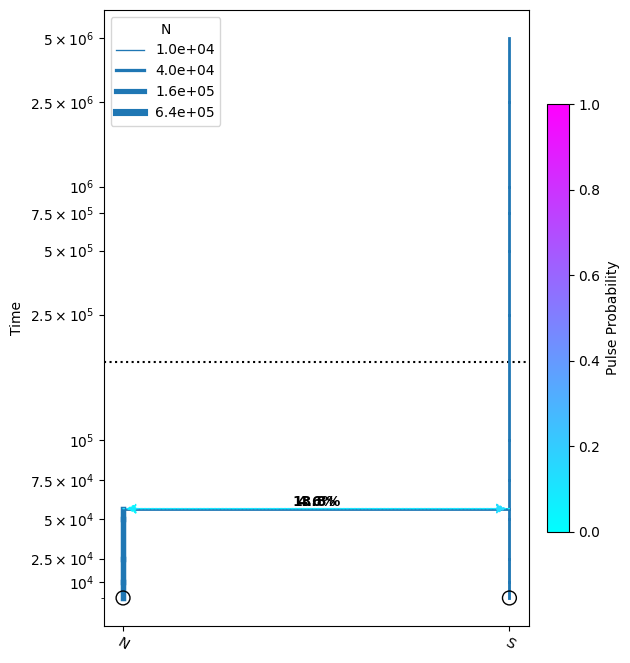

In [127]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model2c_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [128]:
#Modelo 2d -migração para os dois lados com expansão do N
prim_model2d = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model2d.set_data(sfs)

prim_model2d.add_time_param("tmig_N_S", lower=5e3, upper=5e6)
prim_model2d.add_time_param("tmig_S_N", lower=5e3, upper=5e6)
prim_model2d.add_pulse_param("mfrac_N_S", upper=.2)
prim_model2d.add_pulse_param("mfrac_S_N", upper=.2)

#prim_model2d.add_size_param("n_N", lower=5e3,upper=1e6)
#prim_model2d.add_size_param("n_S", lower=5e3,upper=1e6)
prim_model2d.add_time_param("tdiv",lower=5e3, upper=5e6, lower_constraints=["tmig_N_S", "tmig_S_N"])
prim_model2d.add_growth_param("g_N", lower=1e-6, upper=1e-3)

prim_model2d.add_leaf("S",N=2e5)
prim_model2d.add_leaf("N", N=3e4, g="g_N")
prim_model2d.move_lineages("N", "S", t="tmig_N_S", p="mfrac_N_S")
prim_model2d.move_lineages("S", "N", t="tmig_S_N", p="mfrac_S_N")
prim_model2d.set_size("N", t="tdiv", g=0)

prim_model2d.move_lineages("N", "S", t="tdiv")
prim_model2d.optimize()

            fun: 0.9861764006887948
            jac: array([ 2.53602819e-08,  1.89508596e-07, -5.20629137e-03,  7.95388191e-09,
        2.91716571e-08,  2.75283252e+03])
  kl_divergence: 0.9861764006887948
 log_likelihood: -1794.1450537799287
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 58
            nit: 12
     parameters: ParamsDict({'tmig_N_S': 21513.699265028707, 'tmig_S_N': 87467.37627510916, 'mfrac_N_S': 0.2, 'mfrac_S_N': 3.216683050734361e-07, 'tdiv': 96569.62453796425, 'g_N': 1.0000000000000243e-06})
         status: 1
        success: True
              x: array([-5.70869087e+00, -4.08714212e+00, -1.38629436e+00, -1.49497446e+01,
       -6.28916887e+00,  1.00000000e-06])

In [129]:
### repetitions ###

results = []
n_runs = 10
prim_model2d_copy = prim_model2d.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model2d.set_params(prim_model2d.get_params(),randomize=True)
    results.append(prim_model2d_copy.optimize(method='L-BFGS-B'))
    lik=prim_model2d_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model2d_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)


Starting run 1 out of 10...
-1794.1450537799287
Starting run 2 out of 10...
-1794.1450537799287
Starting run 3 out of 10...
-1794.1450537799287
Starting run 4 out of 10...
-1794.1450537799287
Starting run 5 out of 10...
-1794.1450537799287
Starting run 6 out of 10...
-1794.1450537799287
Starting run 7 out of 10...
-1794.1450537799287
Starting run 8 out of 10...
-1794.1450537799287
Starting run 9 out of 10...
-1794.1450537799287
Starting run 10 out of 10...
-1794.1450537799287


In [131]:
#### output
file = open("bestrun_prim.txt","a")
file.write("Model=model2d" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model2d = best_result
f = open("prim_model2d.pkl","wb")
pickle.dump(prim_model2d,f)
f.close()

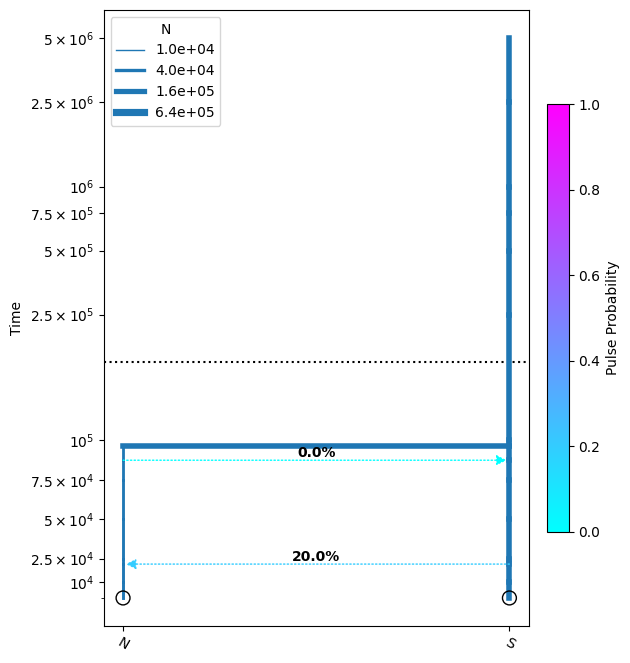

In [132]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model2d_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [148]:
#Modelo 3a - isolamento sem migração
prim_model3a = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model3a.set_data(sfs)

prim_model3a.add_time_param("tdiv", lower=5e3, upper=5e6)

prim_model3a.add_leaf("S", N=2e5)
prim_model3a.add_leaf("N", N=3e4)

prim_model3a.move_lineages("N", "S", t="tdiv")

prim_model3a.optimize()

            fun: 0.9939385238939271
            jac: array([2.34874472e-07])
  kl_divergence: 0.9939385238939271
 log_likelihood: -1797.44395614211
        message: 'Local minimum reached (|pg| ~= 0)'
           nfev: 10
            nit: 4
     parameters: ParamsDict({'tdiv': 64828.269012983896})
         status: 0
        success: True
              x: array([-4.41266447])

In [134]:
### repetitions ###

results = []
n_runs = 10
prim_model3a_copy = prim_model3a.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model3a.set_params(prim_model3a.get_params(),randomize=True)
    results.append(prim_model3a_copy.optimize(method='L-BFGS-B'))
    lik=prim_model3a_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model3a_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)


Starting run 1 out of 10...
-1797.4439561420645
Starting run 2 out of 10...
-1797.4439561420645
Starting run 3 out of 10...
-1797.4439561420645
Starting run 4 out of 10...
-1797.4439561420645
Starting run 5 out of 10...
-1797.4439561420645
Starting run 6 out of 10...
-1797.4439561420645
Starting run 7 out of 10...
-1797.4439561420645
Starting run 8 out of 10...
-1797.4439561420645
Starting run 9 out of 10...
-1797.4439561420645
Starting run 10 out of 10...
-1797.4439561420645


In [135]:
#### output
file = open("bestrun_prim.txt","a")
file.write("Model=model3a" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model3a = best_result
f = open("prim_model3a.pkl","wb")
pickle.dump(prim_model3a,f)
f.close()


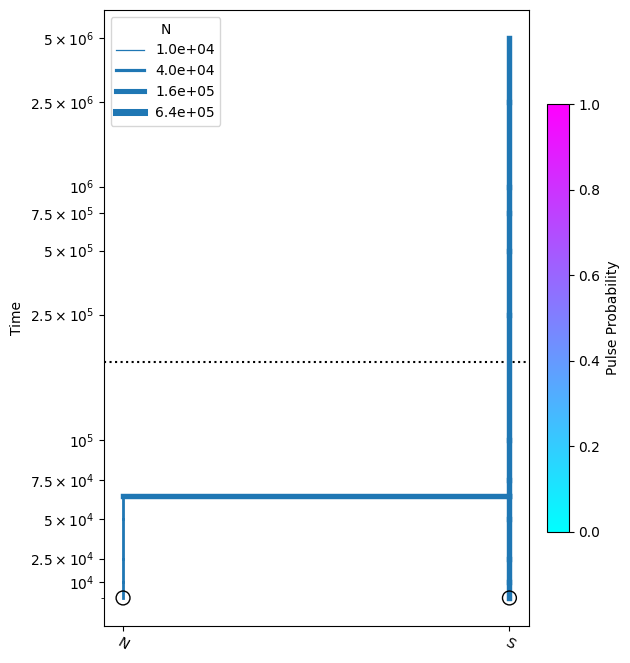

In [136]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model3a_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [137]:
#Modelo 3b - migração ambos os lados, sem expasão
prim_model3b = momi.DemographicModel(N_e=1e5,gen_time=4.72, muts_per_gen=2.5e-9)

prim_model3b.set_data(sfs)

prim_model3b.add_time_param("tmig_N_S", lower=5e3, upper=5e6)
prim_model3b.add_time_param("tmig_S_N", lower=5e3, upper=5e6)
prim_model3b.add_pulse_param("mfrac_N_S", upper=.2)
prim_model3b.add_pulse_param("mfrac_S_N", upper=.2)

prim_model3b.add_time_param("tdiv", lower=5e3, upper=5e6, lower_constraints=["tmig_N_S", "tmig_S_N"])

#prim_model3b.add_size_param("n_S", lower=5e3,upper=1e6)
#prim_model3b.add_size_param("n_N", lower=5e3,upper=1e6)

prim_model3b.add_leaf("N", N=2e5)
prim_model3b.add_leaf("S", N=3e4)
prim_model3b.move_lineages("N", "S", t="tmig_N_S", p="mfrac_N_S")
prim_model3b.move_lineages("S", "N", t="tmig_S_N", p="mfrac_S_N")

prim_model3b.move_lineages("N", "S", t="tdiv")

prim_model3b.optimize()


            fun: 1.335489356070209
            jac: array([-5.19008512e-06,  2.93262589e-09,  5.12578588e-10, -9.74065706e-03,
        5.05063794e-10])
  kl_divergence: 1.335489356070209
 log_likelihood: -1942.6030598170298
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 26
            nit: 7
     parameters: ParamsDict({'tmig_N_S': 108252.20825304324, 'tmig_S_N': 5000.013331872912, 'mfrac_N_S': 0.0020334656581612255, 'mfrac_S_N': 0.2, 'tdiv': 108252.39545525885})
         status: 1
        success: True
              x: array([ -3.85813032, -19.74154562,  -6.19597818,  -1.38629436,
       -17.07862606])

In [138]:
### repetitions ###

results = []
n_runs = 10
prim_model3b_copy = prim_model3b.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model3b.set_params(prim_model3b.get_params(),randomize=True)
    results.append(prim_model3b_copy.optimize(method='L-BFGS-B'))
    lik=prim_model3b_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model3b_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)

Starting run 1 out of 10...
-1942.6030598170298
Starting run 2 out of 10...
-1942.6030598170298
Starting run 3 out of 10...
-1942.6030598170298
Starting run 4 out of 10...
-1942.6030598170298
Starting run 5 out of 10...
-1942.6030598170298
Starting run 6 out of 10...
-1942.6030598170298
Starting run 7 out of 10...
-1942.6030598170298
Starting run 8 out of 10...
-1942.6030598170298
Starting run 9 out of 10...
-1942.6030598170298
Starting run 10 out of 10...
-1942.6030598170298


In [139]:
#### output
file = open("bestrun_prim.txt","a")
file.write("Model=model3b" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model3b = best_result
f = open("prim_model3b.pkl","wb")
pickle.dump(prim_model3b,f)
f.close()

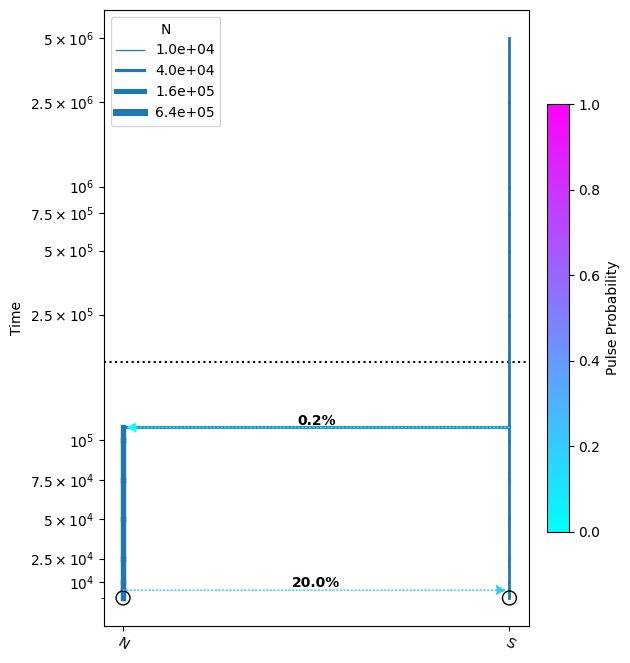

In [141]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model3b_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [142]:
%%bash
awk -f list_to_table.awk bestrun_prim.txt > table_logs_prim.csv

In [143]:
import pandas as pd

import numpy as np

df1 = pd.read_csv('table_logs_prim.csv', sep='\t')

df1['AICs'] = (2*df1['n_parameters'] - 2*df1['Log_likelihood'])

df1['Delta_AIC'] = np.array(df1['AICs']) - np.min(df1['AICs'])

df1['weight_AICs'] = np.exp(-0.5*df1['Delta_AIC'])

df1.to_csv('table_AICs_prim_final.csv', sep='\t')

In [149]:
## Melhor modelo 3a ou 2d - vou fazer com o 2d
#Modelo 2d -migração para os dois lados com expansão do N
prim_model2d = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model2d.set_data(sfs)

prim_model2d.add_time_param("tmig_N_S", lower=5e3, upper=5e6)
prim_model2d.add_time_param("tmig_S_N", lower=5e3, upper=5e6)
prim_model2d.add_pulse_param("mfrac_N_S", upper=.2)
prim_model2d.add_pulse_param("mfrac_S_N", upper=.2)

#prim_model2d.add_size_param("n_N", lower=5e3,upper=1e6)
#prim_model2d.add_size_param("n_S", lower=5e3,upper=1e6)
prim_model2d.add_time_param("tdiv",lower=5e3, upper=5e6, lower_constraints=["tmig_N_S", "tmig_S_N"])
prim_model2d.add_growth_param("g_N", lower=1e-6, upper=1e-3)

prim_model2d.add_leaf("S",N=2e5)
prim_model2d.add_leaf("N", N=3e4, g="g_N")
prim_model2d.move_lineages("N", "S", t="tmig_N_S", p="mfrac_N_S")
prim_model2d.move_lineages("S", "N", t="tmig_S_N", p="mfrac_S_N")
prim_model2d.set_size("N", t="tdiv", g=0)

prim_model2d.move_lineages("N", "S", t="tdiv")


In [151]:
import numpy as np
np.random.seed(100)  # Escolha qualquer número inteiro como semente

n_bootstraps = 10

bootstrap_results = []
for i in range(n_bootstraps):
    print(f"Fitting {i+1}-th bootstrap out of {n_bootstraps}")
    # make copies of the original model to avoid changing them
    prim_model2d_copy = prim_model2d.copy()

    # resample the data
    resampled_sfs = sfs.resample()
    # tell models to use the new dataset
    prim_model2d_copy.set_data(resampled_sfs)
    #add_pulse_copy.set_data(resampled_sfs)

    # choose new random parameters for submodel, optimize
    
    params = prim_model2d_copy.get_params()
    numeric_params = {k: float(v) if hasattr(v, '__float__') else v for k, v in params.items()}
    prim_model2d_copy.set_params(numeric_params, randomize=True)
    prim_model2d_copy.optimize(method='L-BFGS-B')
    # initialize parameters from submodel, randomizing the new parameters
    #add_pulse_copy.set_params(prim_model2db_copy.get_params(),,randomize=True)
    #add_pulse_copy.optimize()

    bootstrap_results.append(prim_model2d_copy.get_params())

Fitting 1-th bootstrap out of 10
Fitting 2-th bootstrap out of 10
Fitting 3-th bootstrap out of 10
Fitting 4-th bootstrap out of 10
Fitting 5-th bootstrap out of 10
Fitting 6-th bootstrap out of 10
Fitting 7-th bootstrap out of 10
Fitting 8-th bootstrap out of 10
Fitting 9-th bootstrap out of 10
Fitting 10-th bootstrap out of 10


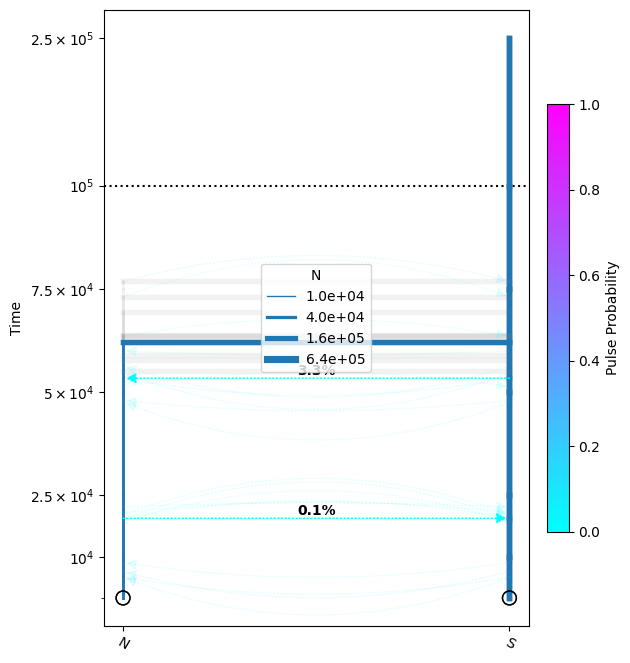

In [154]:
import matplotlib.pyplot as plt

import pickle
yticks=[1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5]
fig = momi.DemographyPlot(
    prim_model2d_copy, ["N", "S"],
    linthreshy=1e5, figsize=(6,8),
    major_yticks=yticks,
    draw=False)

# plot bootstraps onto the canvas in transparency
for params in bootstrap_results:
    fig.add_bootstrap(params,
        # alpha=0: totally transparent. alpha=1: totally opaque
        alpha=1/10)

# now draw the inferred demography on top of the bootstraps
fig.draw()
fig.draw_N_legend(loc="center")
plt.savefig('bootstrap_model2d_prim.pdf')

In [152]:
import pandas as pd
df = pd.DataFrame(bootstrap_results)
df
df.to_csv("bootstrap_prim_model2d.csv", sep=',')